In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [86]:
sns.set(rc={'figure.figsize':(16,10)})
plt.style.use('seaborn-whitegrid')

In [164]:
year = '19'
model = 'model_new'

In [165]:
data = pd.read_csv(f'../outputs/{year}/tables/signal_table{year}.csv', index_col='name')
triggers = pd.read_csv(f'../outputs/{year}/tables/triggers{year}.csv', index_col='name')
reg_eff = pd.read_csv(f'../outputs/{model}/tables/signal_table{model}.csv', index_col='name')

In [166]:
data

,lum,dEmin,dEmax,Emean,Nsig,dNsig
name,,,,,,
537.5,1224.66,0.0,0.0,537.45,1919.88,44.63
550.0,1424.27,0.0,0.0,549.34,1302.27,37.04
550.1,496.83,0.0,0.0,549.67,421.40,21.20
562.5,1048.68,0.0,0.0,562.50,642.85,25.97
575.0,1054.35,0.0,0.0,574.86,493.27,22.69
587.5,1167.38,0.0,0.0,587.73,355.91,19.52
600.0,1161.83,0.0,0.0,599.89,257.17,16.77
612.5,1059.04,0.0,0.0,612.51,183.59,14.17
612.6,1179.14,0.0,0.0,612.61,245.81,16.24


Triggers

In [167]:
triggers.tail()

,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
name,,,,,,,,,
955.0,2.0,2.0,25.0,0.8966,0.8966,0.9893,0.0556,0.0556,0.0081
962.5,1.0,1.0,39.0,0.9524,0.9524,0.9977,0.0325,0.0325,0.0022
975.0,2.0,0.0,83.0,0.9882,0.9655,0.9996,0.0116,0.0195,0.0005
978.0,0.0,0.0,7.0,0.8889,0.8889,0.9877,0.0994,0.0994,0.0156
987.5,1.0,3.0,51.0,0.9286,0.9630,0.9974,0.0341,0.0255,0.0022


In [168]:
reg_eff.head()

,lum,dEmin,dEmax,Emean,Nsig,dNsig
name,,,,,,
550.0,7163,0.0,0.0,550.0,1801.35,44.02
562.5,6307,0.0,0.0,562.5,1573.23,41.43
575.0,5516,0.0,0.0,575.0,1375.20,38.87
587.5,5117,0.0,0.0,587.5,1311.47,37.58
600.0,4606,0.0,0.0,600.0,1134.88,35.69


Get N/L

In [169]:
data['CSvis'] = data['Nsig']/data['lum']
data['dCSvis'] = data['dNsig']/data['lum']

In [170]:
data.shape

(44, 8)

Trigger join

In [171]:
data = data.join(triggers[['TrigEff', 'TrigErr']], how='left')

In [172]:
data.shape #сверить с предыдущим shape

(44, 10)

In [173]:
data = data.drop(['Nsig', 'dNsig', 'lum'], axis=1)

Get Reg_eff

In [174]:
reg_eff['RegEff'] = reg_eff['Nsig']/reg_eff['lum']
reg_eff['RegErr'] = reg_eff['dNsig']/reg_eff['lum']
reg_eff.drop(['dEmax', 'dEmin', 'lum', 'Nsig', 'dNsig'], axis=1, inplace=True)

Reg eff join

In [175]:
data['RegEff'] = data.apply(lambda x: np.interp(x['Emean'], reg_eff.Emean, reg_eff.RegEff), axis=1)
data['RegErr'] = data.apply(lambda x: np.interp(x['Emean'], reg_eff.Emean, reg_eff.RegErr), axis=1)

Recalc cross section

In [176]:
data['CS'] = data['CSvis']/data['TrigEff']/data['RegEff'];
data['dCS'] = data['CS']*np.sqrt( np.square( data['dCSvis']/data['CSvis'] ) + 
                                np.square( data['TrigErr']/data['TrigEff'] ) + 
                                np.square( data['RegErr']/data['RegEff'] ))

In [177]:
#data.drop(['CSvis', 'dCSvis', 'TrigEff', 'TrigErr', 'RegEff', 'RegErr'], axis=1, inplace=True)

In [178]:
data.to_csv(f'../outputs/{year}/tables/result_visible.csv', float_format='%.5f')

## Draw cross sections

In [179]:
cs11 = pd.read_csv('../outputs/11/tables/result_visible.csv', index_col=['name'])
cs12 = pd.read_csv('../outputs/12/tables/result_visible.csv', index_col=['name'])
cs17 = pd.read_csv('../outputs/17/tables/result_visible.csv', index_col=['name'])
cs19 = pd.read_csv('../outputs/19/tables/result_visible.csv', index_col=['name'])

In [180]:
#radcor = pd.read_csv('rad_cors.dat', delimiter='\t', names=['energy', 'radcor'], index_col=['energy'])
radcor = pd.read_csv('../outputs/radcors.dat', names=['energy', 'radcor'], index_col=['energy'])
radcor.index *= 0.5e3
radcor = radcor.sort_index()

In [181]:
cs12.tail()

,dEmin,dEmax,Emean,CSvis,dCSvis,TrigEff,TrigErr,RegEff,RegErr,CS,dCS
name,,,,,,,,,,,
860,0.00,0.00,857.92,0.03275,0.00673,0.8520,0.0599,0.12340,0.00317,0.31146,0.06808
880,0.00,0.00,878.86,0.01384,0.00391,0.9474,0.0489,0.11201,0.00332,0.13038,0.03763
920,18.79,19.34,917.80,0.00605,0.00165,0.8611,0.0579,0.08987,0.00396,0.07824,0.02227
950,10.91,9.93,962.51,0.00416,0.00159,0.7466,0.0811,0.06116,0.00384,0.09118,0.03671
960,5.00,5.74,988.50,0.00540,0.00222,0.9184,0.0730,0.04971,0.00409,0.11825,0.05040


In [182]:
# plt.scatter(radcor.index, radcor.radcor)

In [183]:
radcor.head()

,radcor
energy,
525.0,0.856548
530.0,0.852604
540.0,0.856702
550.0,0.862562
562.5,0.870683


In [184]:
cs11['rad'] = np.interp(cs11.Emean, radcor.index, radcor.radcor)
cs12['rad'] = np.interp(cs12.Emean, radcor.index, radcor.radcor)
cs17['rad'] = np.interp(cs17.Emean, radcor.index, radcor.radcor)
cs19['rad'] = np.interp(cs19.Emean, radcor.index, radcor.radcor)

In [185]:
def born(data):
    data['born'] = data.CS/data.rad
    data['born_err'] = data.dCS/data.rad

In [186]:
born(cs11)
born(cs12)
born(cs17)
born(cs19)

In [187]:
errE = dict()
errE[11] = [cs11.dEmin*2e-3, cs11.dEmax*2e-3]
errE[12] = [cs12.dEmin*2e-3, cs12.dEmax*2e-3]
errE[17] = [cs17.dEmin*2e-3, cs17.dEmax*2e-3]
errE[19] = [cs19.dEmin*2e-3, cs19.dEmax*2e-3]

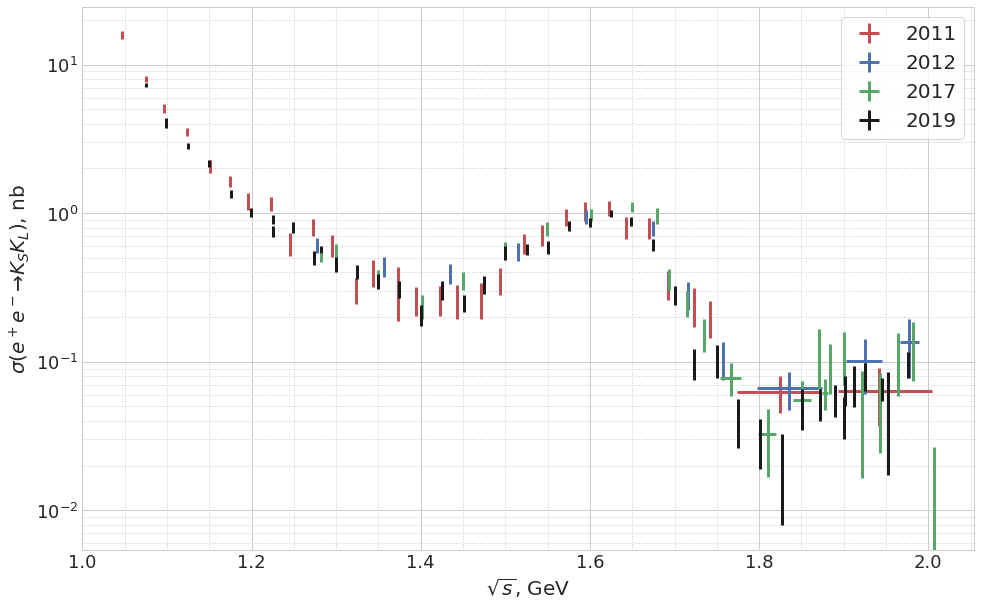

In [189]:
plt.errorbar(cs11.Emean*2e-3, cs11.born, yerr=cs11.born_err, xerr=errE[11], fmt='ro', elinewidth=3, ms=0, label='2011')
plt.errorbar(cs12.Emean*2e-3, cs12.born, yerr=cs12.born_err, xerr=errE[12], fmt='bo', elinewidth=3, ms=0, label='2012')
plt.errorbar(cs17.Emean*2e-3, cs17.born, yerr=cs17.born_err, xerr=errE[17], fmt='go', elinewidth=3, ms=0, label='2017')
plt.errorbar(cs19.Emean*2e-3, cs19.born, yerr=cs19.born_err, xerr=errE[19], fmt='ko', elinewidth=3, ms=0, label='2019')
plt.yscale('log')
plt.xlabel('$\sqrt{s}$, GeV', fontsize=20)
plt.ylabel('$\sigma(e^+e^- \\to K_SK_L)$, nb', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=18);
ax.legend(fontsize=20, frameon=True);

plt.grid(linestyle = '-');
ax = plt.gca();
ax.minorticks_on();
ax.grid(which='minor', linestyle = ':');

plt.savefig('cs.pdf')

### Некоторые проверки

1. Проверить `RegEff`
2. Проверить видимое сечение
3. Проверить триггеры

<ErrorbarContainer object of 3 artists>

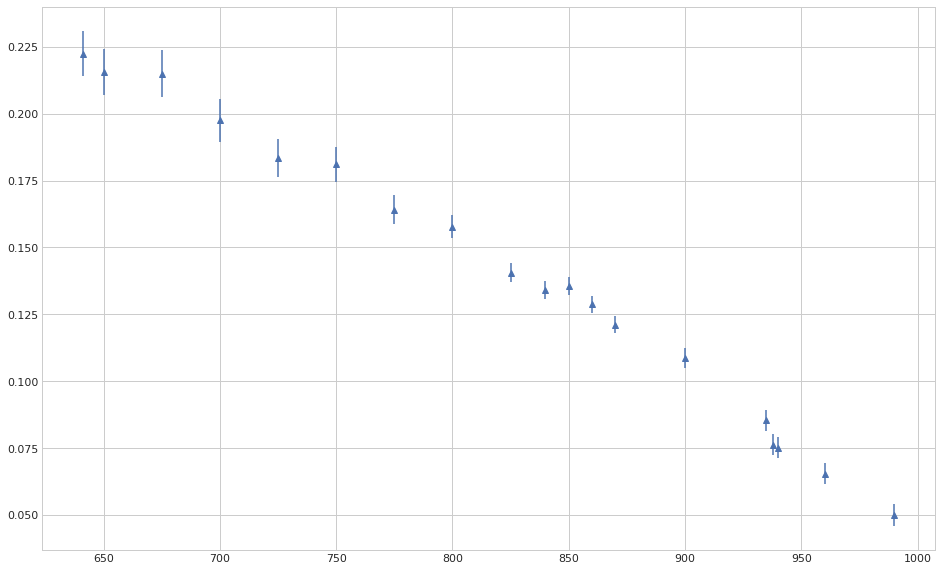

In [109]:
plt.errorbar(data=cs17, x=cs17.index, y='RegEff', yerr='RegErr', fmt='^')

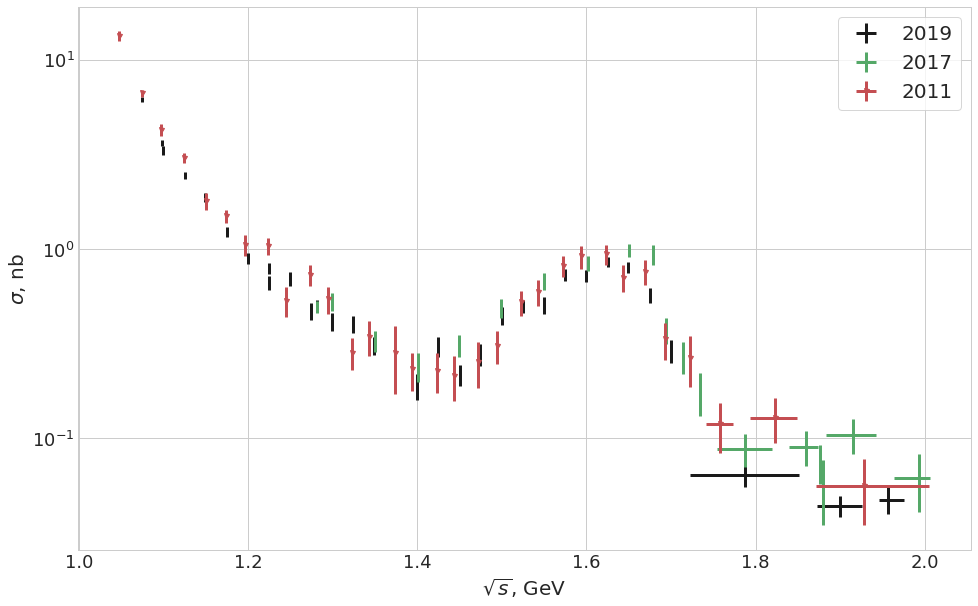

In [144]:
plt.errorbar(cs19.Emean*2e-3, cs19.CS, yerr=cs19.dCS, xerr=errE[19], fmt='kd', elinewidth=3, ms=0, label='2019')
plt.errorbar(cs17.Emean*2e-3, cs17.CS, yerr=cs17.dCS, xerr=errE[17], fmt='g^', elinewidth=3, ms=0, label='2017')
# plt.errorbar(cs12.Emean*2e-3, cs12.CS, yerr=cs12.dCS, xerr=errE[12], fmt='bp', elinewidth=3, ms=5, label='2012')
plt.errorbar(cs11.Emean*2e-3, cs11.CS, yerr=cs11.dCS, xerr=errE[11], fmt='rv', elinewidth=3, ms=5, label='2011')
plt.yscale('log')
plt.xlabel('$\sqrt{s}$, GeV', fontsize=20)
plt.ylabel('$\sigma$, nb', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=18)
ax.legend(fontsize=20, frameon=True)


In [28]:
cs11

,dEmin,dEmax,Emean,CSvis,dCSvis,TrigEff,TrigErr,RegEff,RegErr,CS,dCS,rad,born,born_err
name,,,,,,,,,,,,,,
525.0,0.00,0.00,523.58,1.69314,0.06183,0.5197,0.0202,0.23985,0.00599,13.58314,0.79986,0.856548,15.858002,0.933818
537.5,0.00,0.00,537.41,1.59773,0.05462,0.9714,0.0061,0.23985,0.00599,6.85748,0.29345,0.855641,8.014440,0.342959
550.0,0.00,0.00,548.44,0.77005,0.04053,0.7381,0.0276,0.23985,0.00599,4.34974,0.30108,0.861648,5.048164,0.349423
562.5,0.00,0.00,562.13,0.70477,0.03690,0.9679,0.0099,0.23755,0.00637,3.06522,0.18302,0.870443,3.521450,0.210261
575.0,0.00,0.00,575.31,0.32007,0.02631,0.7425,0.0408,0.23815,0.00681,1.81006,0.18630,0.877349,2.063100,0.212344
587.5,0.00,0.00,587.05,0.33431,0.02671,0.9644,0.0155,0.23984,0.00706,1.44532,0.12522,0.884638,1.633799,0.141549
600.0,0.00,0.00,598.04,0.17402,0.01767,0.7007,0.0498,0.23206,0.00735,1.07025,0.13691,0.889378,1.203370,0.153939
612.5,0.00,0.00,611.71,0.22268,0.02122,0.9492,0.0218,0.22564,0.00787,1.03970,0.10815,0.894639,1.162145,0.120887
625.0,0.00,0.00,622.47,0.10153,0.01603,0.8519,0.0656,0.21242,0.00777,0.56108,0.10069,0.897899,0.624881,0.112140


<ErrorbarContainer object of 3 artists>

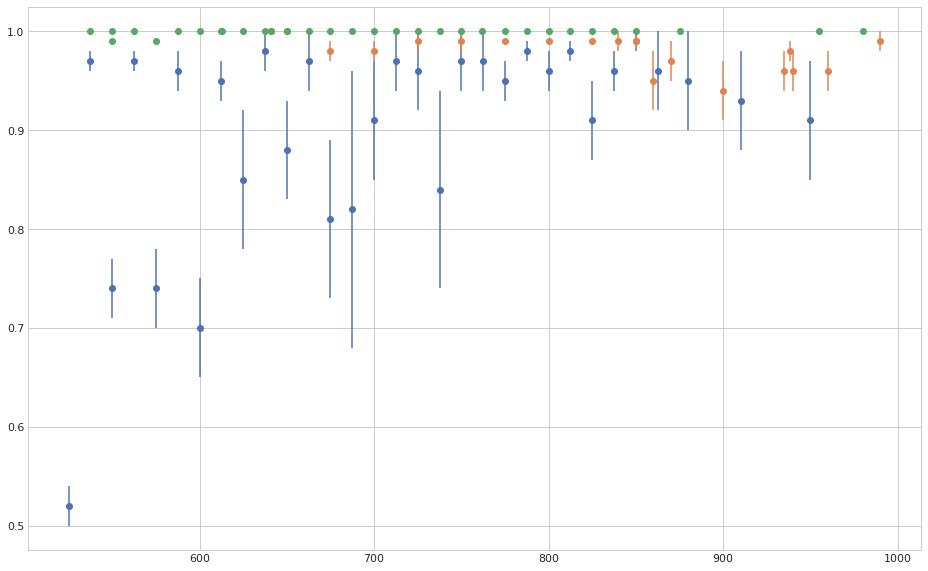

In [143]:
plt.errorbar(data=cs11, x=cs11.index, y='TrigEff', yerr='TrigErr', fmt='o')
plt.errorbar(data=cs17, x=cs17.index, y='TrigEff', yerr='TrigErr', fmt='o')
plt.errorbar(data=cs19, x=cs19.index, y='TrigEff', yerr='TrigErr', fmt='o')